# NSTI data preprocessing

In [1]:
import numpy as np 
import pandas as pd # data import and maniplation 
import os, re # file dirtectory , string manipulation
import seaborn as sns # data visualization 
import matplotlib.pyplot as plt # data visualization 
from datetime import datetime, timedelta

from sklearn import datasets, linear_model # regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # data split 
sns.set_style("whitegrid")
!pip install lifelines
from lifelines import KaplanMeierFitter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 337kB 5.1MB/s 


In [2]:
# if I want to change between google collab or spyder 
if True:
    from google.colab import files
    files.upload()    

Saving [Full data- not in use]NSTI antibiotic duration.csv to [Full data- not in use]NSTI antibiotic duration.csv
Saving NSTI_abx_end_date_final_for_KL.csv to NSTI_abx_end_date_final_for_KL.csv
Saving NSTI_Bacteremia_for_KL.csv to NSTI_Bacteremia_for_KL.csv
Saving NSTI_debride_for_KL.csv to NSTI_debride_for_KL.csv
Saving NSTI_for_KL_variables.xlsx to NSTI_for_KL_variables.xlsx
Saving NSTI_labs_for_KL.csv to NSTI_labs_for_KL.csv
Saving NSTI_Updated_3_5_20.csv to NSTI_Updated_3_5_20.csv
Saving NSTI_Updated_Meds_Final_For_KL.csv to NSTI_Updated_Meds_Final_For_KL.csv
Saving NSTI_WBC_updated_for_KL.csv to NSTI_WBC_updated_for_KL.csv


In [0]:
# Input of data 
df = pd.read_csv("NSTI_Updated_3_5_20.csv", na_values = ["NA"]) # base dataset

med_df = pd.read_csv("NSTI_Updated_Meds_Final_For_KL.csv", na_values = ["NA"]) # dataset with the time series data for all meds of patients 
debride_df = pd.read_csv("NSTI_debride_for_KL.csv", na_values = ["NA"])
compli_df = pd.read_csv("NSTI_abx_end_date_final_for_KL.csv")
#nsti_wbc = pd.read_csv("NSTI_WBC_updated_for_KL.csv") # wbc counts not really needed
#nsti_bac = pd.read_csv("NSTI_Bacteremia_for_KL.csv") # bac data/not needed

# Clean up / merge / Data manipulation

In [0]:
def extra_white_space_rem(dataset):
  df = dataset.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  df.columns =  df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  df['patient.x'] = pd.to_numeric(df['patient.x'].str.split("*", n = 1, expand = True)[0])
  return df

def remove_entry(dataset,column):
  return dataset[~dataset[column].isin(["NOT", "","UNK","NA"])]

In [0]:
#issues with extra white spaces 
df = extra_white_space_rem(df)
med_df = extra_white_space_rem(med_df)
debride_df = extra_white_space_rem(debride_df)
compli_df = extra_white_space_rem(compli_df)

#Timedata NA / Unneeded meds for particular columns removes bad entries 
debride_df = remove_entry(debride_df,"admit.date.x")
debride_df = remove_entry(debride_df, "minutes.from")

## Combining date and time and converting it to time date format

Also converting the time of wbc for validation

In [0]:
# formating debride data
debride_df['dc.date']  = pd.to_datetime(debride_df['dc.date'].apply(lambda x: str(x).strip(" ")), format = '%m/%d/%Y')
debride_df['1st.debride']  = debride_df['debride.1.start.date'] + " " + debride_df['debride.1.start.time']
debride_df['1st.debride'] = pd.to_datetime(debride_df['1st.debride'].apply(lambda x: str(x).strip(" ")), format = '%m/%d/%Y %H:%M')
debride_df['minutes.from.1st.deb.to.last'] = debride_df['minutes.from.1st.deb.to.last'].apply(lambda x : timedelta(minutes = int(x)))
debride_df['minutes.from.admit.to.1st.debride'] = debride_df['minutes.from.admit.to.1st.debride'].apply(lambda x : timedelta(minutes = int(x)))
debride_df['total.time'] =  debride_df['1st.debride'] + debride_df['minutes.from.1st.deb.to.last']
debride_df['admission.time'] = debride_df['1st.debride'] - debride_df['minutes.from.admit.to.1st.debride']

df['comp_arrival_time'] = df['hospital.arrival.date'] + ' ' + df['hospital.arrival.time']
df['comp_arrival_time'] = pd.to_datetime(df['comp_arrival_time'].apply(lambda x: str(x).strip(" ")), format = '%H:%M %m/%d/%y')
# Calculate time between admission and abx event
med_df = med_df.merge(df[['patient.x','comp_arrival_time']], how = 'left' ,on = 'patient.x')
med_df['event_end_dt_tm'] = pd.to_datetime(med_df['event_end_dt_tm'].apply(lambda x: str(x).strip(" ")), format = '%m/%d/%y %H:%M')
med_df['time_to_abx'] = med_df['event_end_dt_tm']-med_df['comp_arrival_time']

compli_df['end_time_simple'] = pd.to_datetime(compli_df['last_nsti_abx_day_observed'].apply(lambda x: x), format = '%m/%d/%y')
compli_df['last_debride_date'] = pd.to_datetime(compli_df['last_debride_date'].apply(lambda x: x), format = '%m/%d/%y')

In [0]:
recentMed_df = med_df.sort_values(by = ['patient.x','time_to_abx'], ascending = [True, False]).drop_duplicates(subset = ['patient.x'], keep = 'first')
med_debride_df = recentMed_df.merge(debride_df[['patient.x','total.time','dc.date']], how= 'inner', on = 'patient.x')

comp_med_df = compli_df.merge(recentMed_df, how ='left', on = 'patient.x')
comp_med_df['abx_from_debride'] =  (comp_med_df['end_time_simple'] - comp_med_df['last_debride_date'] ) / timedelta(minutes = 60)
comp_med_df['abx_from_admission'] = (comp_med_df['end_time_simple'] - comp_med_df['comp_arrival_time'] ) / timedelta(minutes = 60)
comp_med_df = comp_med_df.merge(df[['patient.x', 'outcome']], how = 'inner', on= 'patient.x')

# NSTI - table calculations

#Individal Antibiotics - Table 4



In [0]:
# Setting up breakdown of outcomes and table aggregation 
mode = ''
med_24 = med_df[(med_df['time_to_abx'] >= timedelta(seconds = 0)) & (med_df['time_to_abx'] <= timedelta(days = 1))].sort_values(by = ['patient.x', 'event_cd_descr'])
if mode == 'Surv':
  med_24 = med_24.merge(df[df['outcome'] == 'A'][['patient.x']].drop_duplicates(), how = 'inner', on = 'patient.x' )
if mode == 'Dead':
  med_24 = med_24.merge(df[df['outcome'] == 'D'][['patient.x']].drop_duplicates(), how = 'inner', on = 'patient.x' )

med_24['value'] = 1
med_24 = med_24[['patient.x', 'event_cd_descr', 'value']].drop_duplicates().pivot(index = 'patient.x', columns = 'event_cd_descr', values = 'value').merge(df[['patient.x', 'perineum.involved']] , how= 'inner', on = 'patient.x')
med_24 = med_24.fillna(0)
for i in ['vancomycin','clindamycin','levofloxacin','penicillin G potassium','piperacillin-tazobactam','meropenem','ciprofloxacin','metronidazole','gentamicin']:
  if i not in med_24.columns:
    med_24[i] = 0

In [9]:
def precentage_pull(dataset, genes, last_or = False):
  if len(genes) == 1:
    return (dataset[genes[0]] == 1)
  if last_or and len(genes) == 2:
    return (dataset[genes[0]] == 1) | precentage_pull(dataset, genes[1:],last_or)
  else:
    return (dataset[genes[0]] == 1) & precentage_pull(dataset, genes[1:],last_or)

def output_table(name,df):
  print('{}: {} ({}%)'.format(name,df ,round( 100*(df/len(med_24)),2)))
print(len(med_24))
output_table('Non-Fourniers',len(med_24[precentage_pull(med_24,['vancomycin', 'clindamycin', 'penicillin G potassium','levofloxacin'])]))
output_table('Fourniers',len(med_24[precentage_pull(med_24,['vancomycin', 'clindamycin', 'piperacillin-tazobactam','meropenem'], True)]))
output_table('Neutropenia',len(med_24[precentage_pull(med_24,['vancomycin', 'clindamycin', 'penicillin G potassium','gentamicin'])]))
output_table('Penicillin Allergic',len(med_24[precentage_pull(med_24,['vancomycin', 'clindamycin', 'levofloxacin'])]))
output_table('All - Regimens',len(med_24[(med_24['vancomycin'] == 1) & (med_24['clindamycin'] == 1)  & 
                                        (((med_24['penicillin G potassium'] == 1) & ((med_24['levofloxacin'] == 1) | (med_24['gentamicin'] == 1))) | ((med_24['meropenem'] == 1) |(med_24['piperacillin-tazobactam'] == 1)) |(med_24['levofloxacin'] == 1) ) 
                                        ]))

439
Non-Fourniers: 217 (49.43%)
Fourniers: 175 (39.86%)
Neutropenia: 12 (2.73%)
Penicillin Allergic: 256 (58.31%)
All - Regimens: 380 (86.56%)


# Table 5

In [10]:
med_df.sort_values(by = ['patient.x', 'time_to_abx','event_cd_descr'], ascending = [True, False,True]).drop_duplicates(subset = ['patient.x','event_cd_descr'], keep = 'first').head(10)

,event_end_dt_tm,event_cd_descr,patient.x,comp_arrival_time,time_to_abx
10268,2015-04-22 09:33:00,meropenem,1,2015-03-18 13:42:00,34 days 19:51:00
10138,2015-03-28 09:01:00,vancomycin,1,2015-03-18 13:42:00,9 days 19:19:00
10289,2015-03-25 09:47:00,clindamycin,1,2015-03-18 13:42:00,6 days 20:05:00
10273,2015-03-25 08:31:00,penicillin G potassium,1,2015-03-18 13:42:00,6 days 18:49:00
10220,2015-03-24 21:47:00,levofloxacin,1,2015-03-18 13:42:00,6 days 08:05:00
10026,2015-03-27 12:52:00,cefazolin,2,2015-03-11 21:59:00,15 days 14:53:00
10012,2015-03-19 09:15:00,meropenem,2,2015-03-11 21:59:00,7 days 11:16:00
10060,2015-03-16 13:27:00,clindamycin,2,2015-03-11 21:59:00,4 days 15:28:00
10010,2015-03-16 13:27:00,penicillin G potassium,2,2015-03-11 21:59:00,4 days 15:28:00
10073,2015-03-15 15:13:00,vancomycin,2,2015-03-11 21:59:00,3 days 17:14:00


In [0]:
def extract_median(df):
  baseline = df.sort_values(by = ['patient.x', 'event_end_dt_tm','event_cd_descr'], ascending = [True, True,True]).drop_duplicates(subset = ['patient.x','event_cd_descr'], keep = 'first')
  end = df.sort_values(by = ['patient.x', 'event_end_dt_tm','event_cd_descr'], ascending = [True, False,True]).drop_duplicates(subset = ['patient.x','event_cd_descr'], keep = 'first')
  final = baseline.merge(end[['patient.x','event_end_dt_tm','event_cd_descr']], how = 'left', on = ['patient.x','event_cd_descr'])
  final['abx_dur'] = (final['event_end_dt_tm_y'] - final['event_end_dt_tm_x']).dt.total_seconds() / 3600
  return final

# overall median abx
def overall_abx_median(df, abx_range):
  df = df[df['event_cd_descr'].isin( abx_range)]
  print(len(df['patient.x'].drop_duplicates()))
  first_time = df.sort_values(by = ['patient.x', 'event_end_dt_tm_x'], ascending = [True, True]).drop_duplicates(subset = ['patient.x'], keep = 'first')
  end_time = df.sort_values(by = ['patient.x', 'event_end_dt_tm_y'], ascending = [True, False]).drop_duplicates(subset = ['patient.x'], keep = 'first')
  temp = first_time[['patient.x','event_end_dt_tm_x']].merge(end_time[['patient.x','event_end_dt_tm_y']], how = 'left', on = 'patient.x')
  temp['differnece'] = temp['event_end_dt_tm_y'] - temp['event_end_dt_tm_x']
  print(temp['differnece'].median())
  #return temp['differnece'].median()

# Subset df for complication 
def complication_return(df, infection):
  return df.merge(compli_df[compli_df['infectious_complication']==infection], how = 'inner', on ='patient.x')

def median_pull(abx):
  overall_abx_median(med_extract_abx,abx) #overall duration abx median
  overall_abx_median(complication_return(med_extract_abx,'Y'),abx) #complicated
  overall_abx_median(complication_return(med_extract_abx,'N'),abx) #uncomplicated

In [0]:
med_extract_abx = extract_median(med_df)

In [16]:
overall = ['vancomycin','clindamycin','levofloxacin','penicillin G potassium','piperacillin-tazobactam','meropenem','ciprofloxacin','metronidazole','gentamicin']
median_pull(overall)
print('vancomycin')
median_pull(['vancomycin'])
print('clindamycin')
median_pull(['clindamycin'])

439
7 days 22:33:00
80
13 days 10:16:30
359
7 days 06:26:00
vancomycin
423
3 days 02:41:00
74
5 days 14:56:00
349
2 days 23:22:00
clindamycin
432
4 days 01:16:30
78
4 days 09:59:00
354
4 days 00:10:00


Table 6

In [22]:
def incdec_test(x, i, nf= False):
  temp = ''
  for x,y in  zip(test, test[1:]):
    if x > y:
      temp = temp + 'd'
    elif x < y:
      temp = temp + 'i'
    #else:
      #temp.append('-')
  if 'di' in temp:
    nf = True
  print('{}|{} |{}'.format( i,nf, temp))

for i in med_df['patient.x'].unique():
  test = med_df[med_df['patient.x'] == i ]['event_end_dt_tm'].dt.floor('d').value_counts().rename_axis('date').reset_index(name='count').sort_values(by = 'date')['count'].to_list()
  n = len(test)
  if n != 1:
    incdec_test(test, i)

936|True |ididdd
674|True |idddid
116|True |dddddid
147|True |iddiiddddd
882|True |iidididiidddid
76|True |ddiddd
182|True |idddiddididd
784|False |iidd
133|True |iddid
652|True |ididddd
155|True |ididiiddddiidiidiididdidiidd
666|True |idiidddiidd
748|False |d
873|True |ididddiidid
778|False |iddd
755|True |ididdid
720|False |idddd
657|True |ddiddid
156|False |iddddd
751|True |idiiddd
924|True |iiiddiiddiiididid
659|True |ididddidid
647|False |iiiddd
871|False |id
850|False |iiddddddd
183|False |idd
744|True |iiiddddid
817|False |iddd
39|True |iddiiidddd
776|True |ididdidd
162|True |idddiiiddiddididd
161|False |iddd
682|False |idddd
671|False |idd
78|False |iddd
934|False |d
89|True |idididdidiiidididddiid
746|False |idd
895|False |idd
132|True |iiddidd
96|True |iidiiiddddid
729|False |iidd
55|True |dddddidddd
113|True |iddddiidddididiididdd
69|True |idiidddd
848|False |id
119|False |iddd
641|False |ddddd
925|True |dddddiidididididd
102|False |iiddd
126|True |idididdd
782|True |iiddddi

# Questions


## Characterize current antibiotic use patterns amongst SURVIVORS:

In [0]:
question_bank = {'1a': '1a: Median duration of antibiotics (time from admission until last antibiotic is stopped)',
                 '1b': '1b: Median duration between last antibiotic and last debridement',
                 '1c': '1c: WBC at time last antibiotic was stopped (closest preceding WBC)',
                 '1d': '1d: What proportion of people were still on antibiotics when their WBC drops',
                 '1e': '1e: Do these look different for people with and without bacteremia?',
                 '1f': '1f: Median number of different antibiotics given per hospital day (like 2f but survivors only)',
                 '2a': '2a: Proportion that received what would be considered adequate coverage:',
                 '2b': '2b: Proportion of people with Perineum.Involved==1 who got:'}
def graph_pure(dataset,x, y,question, threshold = False):
  fig, ax = plt.subplots(figsize=(15,6))
  if threshold:
    sns.boxplot(ax = ax, data = dataset[(dataset[x] > 0) & (dataset[x] < threshold)], x = x, y = y).set_title(question_bank[question])
  else: 
    sns.boxplot(ax = ax, data = dataset[(dataset[x] > 0)], x = x, y = y).set_title(question_bank[question])
  
def median_metics(dataset, x, threshold, question):
  print('{0} \nOverall: {1} \nSurvivors: {2} \nNon-Survivors: {3} \n'.format(question_bank[question],
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold)][x].median(),
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['outcome'] == 'A')][x].median(),
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['outcome'] == 'D')][x].median()))
def prop_patient(value):
    print('Full: {0}: '.format(value) + str(len(nsti_wbct[nsti_wbct['wbc'] < value]['patient.x'].unique())/ len(nsti_wbct['patient.x'].unique())))

def median_metics_bac(dataset, x, threshold, question):
  print('{0} \nOverall: {1} \nBad: {2} \nNon-bad {3} \n'.format(question_bank[question],
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold)][x].median(),
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['lab.code'] == 0)][x].median(),
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['lab.code'] == 1)][x].median()))

In [0]:
# For 1c: filters the observations that are before the last date of operation 
# takes the closet date 
wbc_med = nsti_wbct.merge(testmedt[['patient.x', 'total.time','meds']], how = 'inner', on = 'patient.x')
wbc_med['difference'] = (wbc_med['specimenreceiveddttm'] - wbc_med['total.time'])
testwbc =  wbc_med.sort_values(by = ['patient.x', 'specimenreceiveddttm'], ascending = [True, True]).drop_duplicates(subset = ['patient.x'], keep = 'first')
wbc_med = wbc_med.merge(testwbc[['patient.x', 'specimenreceiveddttm']], how = 'left', on = 'patient.x')
wbc_med['baseline'] = wbc_med['specimenreceiveddttm_x'] - wbc_med['specimenreceiveddttm_y']
wbc_med['baseline'] = [ i.total_seconds() / 3600 for i in wbc_med['baseline']]

wbc_24 = wbc_med[(wbc_med['difference'] < timedelta(days =0)) & (wbc_med['difference'] > timedelta(days =-1) ) ].sort_values(by = ['patient.x', 'difference'], ascending = [True, False]).reset_index()
wbc_24_base = wbc_24.merge(nstit[['patient.x', 'outcome']], how = 'inner', on = 'patient.x')


1a: Median duration of antibiotics (time from admission until last antibiotic is stopped) 
Overall: 202.86666666666667 
Survivors: 226.5 
Non-Survivors: 70.58333333333333 

1b: Median duration between last antibiotic and last debridement 
Overall: 137.71666666666667 
Survivors: 159.1 
Non-Survivors: 29.783333333333335 

1c: WBC at time last antibiotic was stopped (closest preceding WBC) 
Overall: 12.58 
Survivors: 11.36 
Non-Survivors: 24.485 



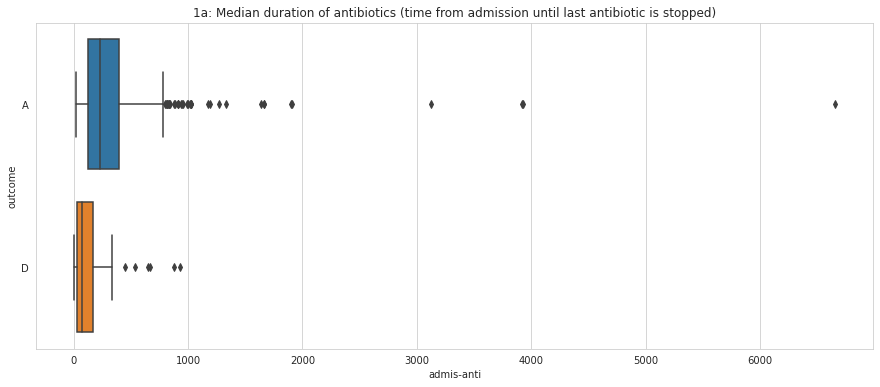

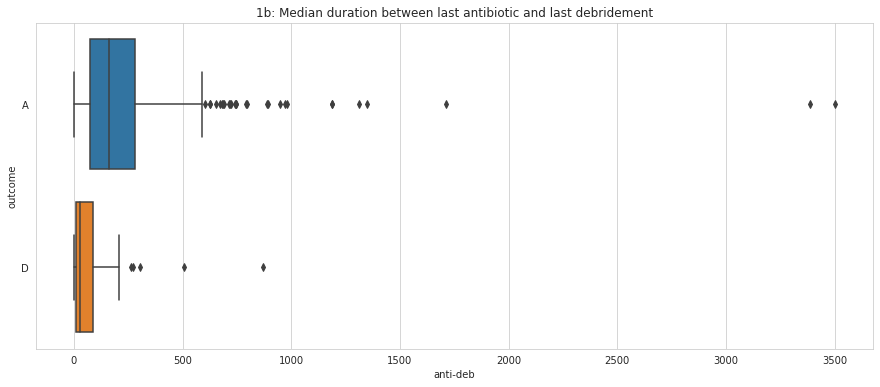

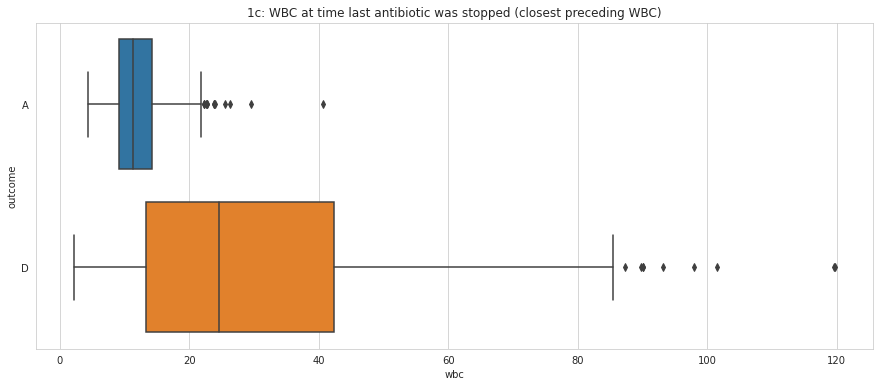

In [0]:
#1a). Median duration of antibiotics (time from admission until last antibiotic is stopped)
graph_pure(lastdeb_lastanti, 'admis-anti', 'outcome','1a')
median_metics(lastdeb_lastanti, 'admis-anti', 2000,'1a')

graph_pure(lastdeb_lastanti, 'anti-deb', 'outcome', '1b', 5000)
median_metics(lastdeb_lastanti,'anti-deb', 5000,'1b')

graph_pure(wbc_24_base, 'wbc', 'outcome','1c')
median_metics(wbc_24_base, 'wbc',max(wbc_24_base['wbc']),'1c')

In [0]:
#1d) What proportion of people were still on antibiotics when their WBC drops <15, <12, <10
# Issues are when their wbc fluatates, could just use the last 15, 12, or 10 score they have 

prop_patient(15)
prop_patient(12)
prop_patient(10)

Full: 15: 0.9349775784753364
Full: 12: 0.8946188340807175
Full: 10: 0.7892376681614349


1a: Median duration of antibiotics (time from admission until last antibiotic is stopped) 
Overall: 204.78333333333333 
Bad: 195.43333333333334 
Non-bad 481.03333333333336 

1b: Median duration between last antibiotic and last debridement 
Overall: 137.86666666666667 
Bad: 128.77499999999998 
Non-bad 302.25 

1d: What proportion of people were still on antibiotics when their WBC drops 
 Overall: 12.59
Surv - Not Bacteremia: 11.36
NonSurv - Bacteremia: 10.98
Surv - Bacteremia: 12.66
NonSurv - Not Bacteremia: 24.905


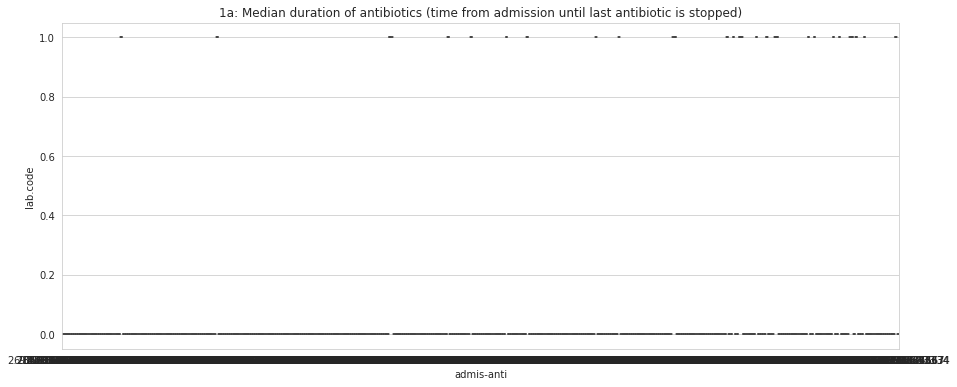

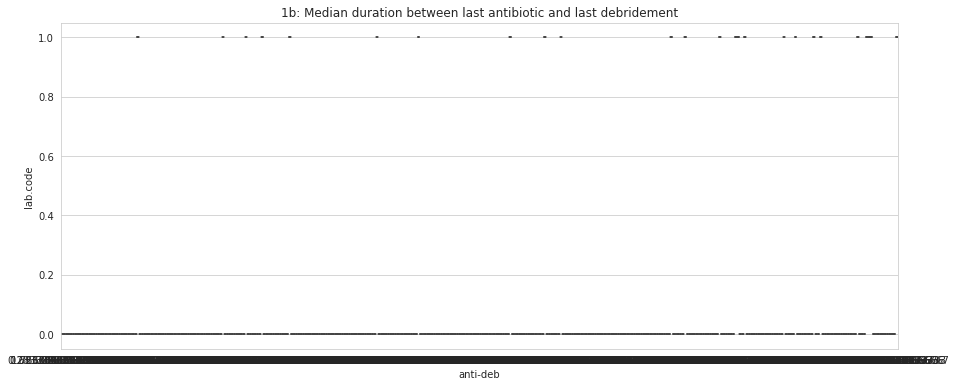

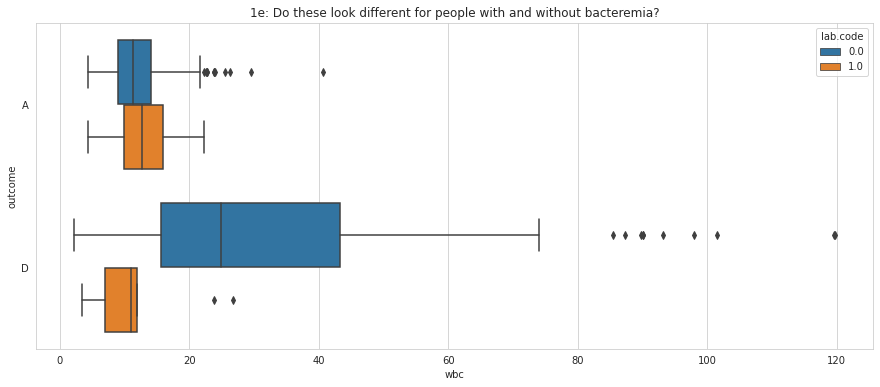

In [0]:
bac_last_deb = lastdeb_lastanti.merge(nsti_bact, how = 'left', on = 'patient.x')
bac_last_deb['lab.code'] = np.nan_to_num(bac_last_deb['lab.code'])

wbc_24_bac = wbc_med[(wbc_med['difference'] < timedelta(days =0)) & (wbc_med['difference'] > timedelta(days =-1) ) ].sort_values(by = ['patient.x', 'difference'], ascending = [True, False]).reset_index()
wbc_24_bac = wbc_24_bac.merge(bac_last_deb[['patient.x', 'lab.code']], how = 'inner', on = 'patient.x').merge(nstit[['patient.x', 'outcome']], how = 'inner', on = 'patient.x')

# 1e. repeat a-d for bacteremia

#1a). Median duration of antibiotics (time from admission until last antibiotic is stopped)
graph_pure(bac_last_deb, 'admis-anti', 'lab.code','1a')
median_metics_bac(bac_last_deb,'admis-anti',7000,'1a' )

#1b. Median duration between last antibiotic and last debridement
median_metics_bac(bac_last_deb,'anti-deb', 7000, '1b')
graph_pure(bac_last_deb, 'anti-deb', 'lab.code', '1b', 5000)

#graph_pure(wbc_24_bac, 'wbc', 'lab.code','1c')
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(ax = ax, data = wbc_24_bac, x = 'wbc', y = 'outcome', hue = 'lab.code').set_title(question_bank['1e'])
print('{0} \n Overall: {1}'.format(question_bank['1d'],wbc_24_bac['wbc'].median()))
print('Surv - Not Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 0) & (wbc_24_bac['outcome'] == 'A')]['wbc'].median()))
print('NonSurv - Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 1)& (wbc_24_bac['outcome'] == 'D')]['wbc'].median()))
print('Surv - Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 1)& (wbc_24_bac['outcome'] == 'A')]['wbc'].median()))
print('NonSurv - Not Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 0)& (wbc_24_bac['outcome'] == 'D')]['wbc'].median()))

In [0]:
nsit_medt_hosp_day =nsti_medt.merge(nstit[['patient.x', 'outcome']], how = 'left', on = 'patient.x')

nsit_medt_hosp_day['admis.diff.days'] = nsit_medt_hosp_day['admis.diff'].apply(lambda x: x.days)
test = nsit_medt_hosp_day[(nsit_medt_hosp_day['outcome'] == 'A') & (nsit_medt_hosp_day['admis.diff.days'] >=0)]

In [0]:
testgraph = test[['meds','admis.diff.days','patient.x']].groupby(['admis.diff.days','patient.x']).agg({"meds":pd.Series.nunique}).reset_index()
for i in testgraph['patient.x'].unique():
  temp = pd.DataFrame(range(max(testgraph[testgraph['patient.x'] == i]['admis.diff.days'])+1,max(testgraph['admis.diff.days'])), columns = ['admis.diff.days'])
  temp['patient.x'] = i
  temp['meds'] = 0
  testgraph = testgraph.append(temp, ignore_index = True )

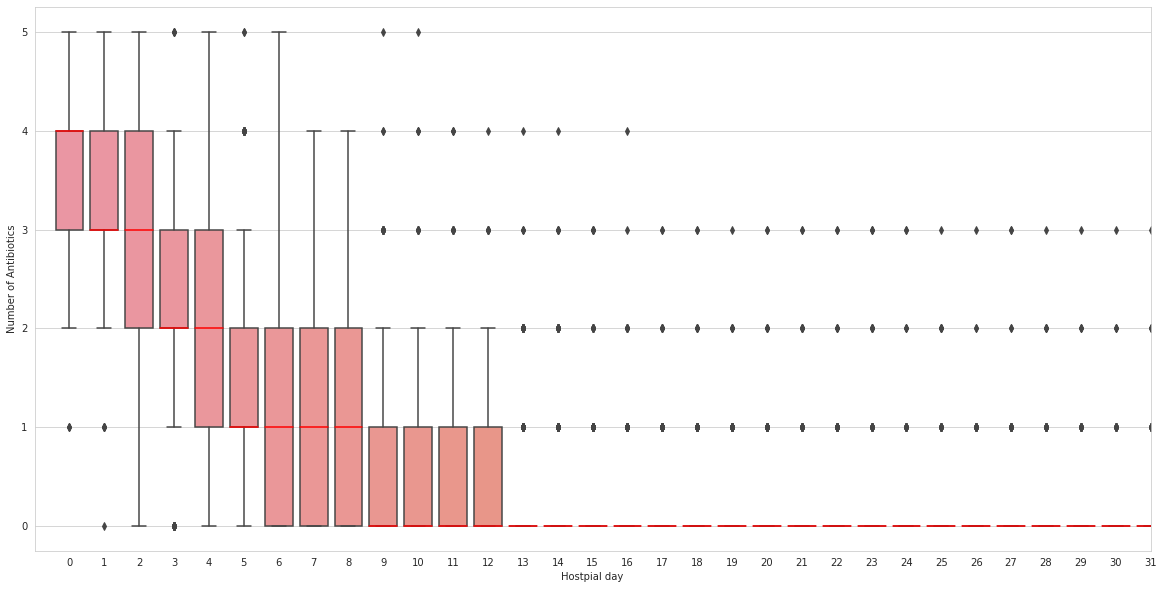

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
plot=sns.boxplot(data = testgraph, x = 'admis.diff.days', y ='meds', ax = ax, medianprops={'color':'red'})
plot.set(xlim=(-1, 31),xlabel='Hostpial day', ylabel= 'Number of Antibiotics')
plt.show()

In [0]:
lastdeb_lastanti[lastdeb_lastanti['admis-anti'] > 336].to_csv('nsti_14.csv')

## 2. Characterize initial antibiotics amongst EVERYONE: 


a). VANC + PCNG + CLIN + LEVO
OR
b). VANC + PCNG + CLIN + GENT
OR
c). VANC + PIPE + CLIN

in the first 24 hours of admission?

In [0]:
#2a sns.distplot(nsti_medt[nsti_medt['admis.diff'] > timedelta(seconds = 0)]['admis.diff'].dt.seconds / 3600)
# nsti_medt.merge(nstit[['patient.x', 'perineum.involved']] , how= 'inner', on = 'patient.x')
testmedtpivot = nsti_medt[(nsti_medt['admis.diff'] > timedelta(seconds = 0)) & (nsti_medt['admis.diff'] < timedelta(days = 1))].sort_values(by = ['patient.x', 'meds'])
testmedtpivot['value'] = 1
testmedtpivot = testmedtpivot[['patient.x', 'meds', 'value']].drop_duplicates().pivot(index = 'patient.x', columns = 'meds', values = 'value').merge(nstit[['patient.x', 'perineum.involved']] , how= 'inner', on = 'patient.x')
testmedtpivot = testmedtpivot.fillna(0)
#testmedtpivot['study_id'] = testmedtpivot.index

In [0]:
len(nsti_medt['patient.x'].unique())

415

In [0]:
def simpl_prop(dataset, gene1, gene2, gene3, gene4 = False):
  if gene4:
    print('{0}, {1}, {2}, {3}: '.format(gene1,gene2, gene3, gene4 ) + 
      str(len(dataset[(dataset[gene1] == 1) & (dataset[gene2] == 1) &
                            (dataset[gene3] == 1) & (dataset[gene4] == 1) ]) #/ len(dataset)
                            )) 
  else:
    print('{0}, {1}, {2}: '.format(gene1,gene2, gene3 ) + 
              str(len(dataset[(dataset[gene1] == 1) & (dataset[gene2] == 1) &
                                    (dataset[gene3] == 1) ]) #/ len(dataset)
                                    )) 

In [0]:
simpl_prop(testmedtpivot,'VANC', 'PCNG', 'CLIN', 'LEVO')
simpl_prop(testmedtpivot,'VANC', 'PCNG', 'CLIN', 'GENT')
simpl_prop(testmedtpivot,'VANC', 'MERO', 'CLIN')
simpl_prop(testmedtpivot,'VANC', 'CLIN', 'PIPE')
simpl_prop(testmedtpivot,'VANC','CLIN', 'LEVO')
print('1-4: ' +str(len(testmedtpivot[(testmedtpivot['VANC'] == 1) & (testmedtpivot['CLIN'] == 1)  & 
                                        (((testmedtpivot['PCNG'] == 1) & ((testmedtpivot['LEVO'] == 1) | (testmedtpivot['GENT'] == 1))) | (testmedtpivot['MERO'] == 1) |(testmedtpivot['PIPE'] == 1)  ) 
                                        ])/ len(testmedtpivot)))
print('1-5: ' +str(len(testmedtpivot[(testmedtpivot['VANC'] == 1) & (testmedtpivot['CLIN'] == 1)  & 
                                        (((testmedtpivot['PCNG'] == 1) & ((testmedtpivot['LEVO'] == 1) | (testmedtpivot['GENT'] == 1))) | (testmedtpivot['MERO'] == 1) |(testmedtpivot['PIPE'] == 1) |(testmedtpivot['LEVO'] == 1) ) 
                                        ])/ len(testmedtpivot)))

VANC, PCNG, CLIN, LEVO: 198
VANC, PCNG, CLIN, GENT: 11
VANC, MERO, CLIN: 56
VANC, CLIN, PIPE: 117
VANC, CLIN, LEVO: 237
1-4: 0.8213399503722084
1-5: 0.8734491315136477


In [0]:
#2a2 
per_inv_medt = testmedtpivot[testmedtpivot['perineum.involved'] == 1]
#simpl_prop(per_inv_medt,'VANC', 'PCNG', 'CLIN', 'LEVO')
#simpl_prop(per_inv_medt,'VANC', 'PCNG', 'CLIN', 'GENT')
simpl_prop(per_inv_medt,'VANC', 'CLIN', 'PIPE')
simpl_prop(per_inv_medt,'VANC', 'MERO', 'CLIN')

print(len(per_inv_medt[(per_inv_medt['VANC'] == 1) & (per_inv_medt['CLIN'] == 1)  & ((per_inv_medt['PIPE'] == 1) | (per_inv_medt['MERO'] == 1))]) / len(per_inv_medt))

VANC, CLIN, PIPE: 87
VANC, MERO, CLIN: 38
0.76


In [0]:
print_individal_anti(nsti_med_calc)

Overall:52
47
51
38
40
12
5
3
2



In [0]:
# get rid of GENT when using the Dead mode
simpl_prop(nsti_med_calc,'VANC', 'PCNG', 'CLIN', 'LEVO')
simpl_prop(nsti_med_calc,'VANC', 'PCNG', 'CLIN', 'GENT')
simpl_prop(nsti_med_calc,'VANC','CLIN', 'LEVO')

print('Founiers ' +str(len(nsti_med_calc[(nsti_med_calc['VANC'] == 1) & (nsti_med_calc['CLIN'] == 1)  & 
                                        ( (nsti_med_calc['MERO'] == 1) |(nsti_med_calc['PIPE'] == 1)  ) 
                                        ])))
print('All - Regimens ' +str(len(nsti_med_calc[(nsti_med_calc['VANC'] == 1) & (nsti_med_calc['CLIN'] == 1)  & 
                                        (((nsti_med_calc['PCNG'] == 1) & ((nsti_med_calc['LEVO'] == 1) | (nsti_med_calc['GENT'] == 1))) | ((nsti_med_calc['MERO'] == 1) |(nsti_med_calc['PIPE'] == 1)) |(nsti_med_calc['LEVO'] == 1) ) 
                                        ])))

VANC, PCNG, CLIN, LEVO: 32


KeyError: ignored

In [0]:
def median_metics(dataset, x, threshold, question):
  print('{0} \nOverall: {1} \nSurvivors: {2} \nNon-Survivors: {3} \n'.format(question_bank[question],
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold)][x].median(),
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['outcome'] == 'A')][x].median(),
                                                   dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['outcome'] == 'D')][x].median()))

In [0]:
# data prep for data 

lastdeb_lastanti[(lastdeb_lastanti['dc.date'] <= lastdeb_lastanti['admission.time'] + timedelta(days = int(14))) & (lastdeb_lastanti['total.time_x'] <= lastdeb_lastanti['dc.date'] ) & (lastdeb_lastanti['total.time_x']  >= lastdeb_lastanti['dc.date'] - timedelta(days = 1) )].to_csv('before_14days.csv')

In [0]:
#table 5 
surv_duration_anti = lastdeb_lastanti.copy()
surv_duration_anti['days_free'] = surv_duration_anti['admis-anti'].apply(lambda x: 28 -  x/24 if (28 -  x/24) >= 0 else 0 )
print('# of patients (Surv):{}'.format(len(surv_duration_anti[surv_duration_anti['outcome'] == 'A']['patient.x'].drop_duplicates())))
# days out of 28
survtest = surv_duration_anti[surv_duration_anti['outcome'] == 'A']
print('{0} days Surv'.format(survtest['days_free'].median()))

# of patients (Surv):360
18.838541666666664 days Surv


In [0]:
surv_duration_anti = surv_duration_anti.merge(nsti_comp[['patient.x','infectious_complication_updated']], how = 'inner', on = 'patient.x')
surv_duration_anti_surv = surv_duration_anti[surv_duration_anti['outcome'] == 'A']
survtest = surv_duration_anti_surv[surv_duration_anti['infectious_complication_updated'] == 'Yes']
print('{} days comp, # of patients: {}'.format(survtest['days_free'].median(), len(survtest['patient.x'].unique())))
survtest = surv_duration_anti_surv[surv_duration_anti['infectious_complication_updated'] != 'Yes']
print('{} days Uncomp, # of patients: {}'.format(survtest['days_free'].median(), len(survtest['patient.x'].unique())))

4.12777777777778 days comp, # of patients: 41
19.76388888888889 days Uncomp, # of patients: 319


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [0]:
# for all antibiotics 
# takes only the most recent date of each patient for med and testwbct
def cus_deb_anti_fc(antibiotic):
  testmedcus = nsti_medt[nsti_medt['meds'] == antibiotic].sort_values(by = ['patient.x','total.time'], ascending = [True, False]).drop_duplicates(subset = ['patient.x'], keep = 'first').copy()

  cus_deb_anti = testmedcus.merge(nsti_debridet[['patient.x','total.time']], how= 'inner', on = 'patient.x')
  cus_deb_anti['anti-deb'] =(cus_deb_anti['total.time_x'] - cus_deb_anti['total.time_y'] ) / timedelta(minutes = 60)
  cus_deb_anti['admis-anti'] =  (cus_deb_anti['total.time_x'] - cus_deb_anti['admission.time'] ) / timedelta(minutes = 60)
  return cus_deb_anti.merge(nstit[['patient.x', 'outcome']], how = 'inner', on= 'patient.x')

# anything zero should go to zero 

def cus_days_from(antibiotic):
  surv_duration_anti = cus_deb_anti_fc(antibiotic)
  surv_duration_anti['days_free'] = surv_duration_anti['admis-anti'].apply(lambda x: 28 -  x/24 if (28 -  x/24) >= 0 else 0 )
  # days out of 28
  survtest = surv_duration_anti[surv_duration_anti['outcome'] == 'A']
  print('{0} days Surv'.format(survtest['days_free'].median()))
  survtest = survtest.merge(nsti_comp[['patient.x','infectious_complication_updated']], how = 'inner', on = 'patient.x')
  non_survtest = survtest[(survtest['outcome'] == 'A') & (survtest['infectious_complication_updated'] != 'Yes')]
  print('{0} days Uncomp'.format(non_survtest['days_free'].median()))
  comp_survtest = survtest[(survtest['outcome'] == 'A') & (survtest['infectious_complication_updated'] == 'Yes')]
  print('{0} days Comp'.format(comp_survtest['days_free'].median()))

In [0]:
 cus_days_from('METR')

21.65625 days Surv
24.582638888888887 days Uncomp
2.5201388888888907 days Comp


In [0]:
#Individal Antibiotics - Table 5
#Kaplan Meier survival curve plotting percentage of patients still on antibiotics on y axis, days on x axis. Survivors only. 
#need table with columns of patient, the antibiotic, if they took it
#https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
# table is each day is a yes or no on if they are on an antibiotic 

In [0]:
kmf = KaplanMeierFitter() 
km_df = surv_duration_anti.copy()

In [0]:
km_df = km_df[(km_df['outcome'] == 'A')]
km_df['admis-anti'] = km_df['admis-anti'].apply(lambda x: x/24 if x >= 0 else 0 )
km_df['meds'] = km_df['meds'].apply(lambda x: 1)

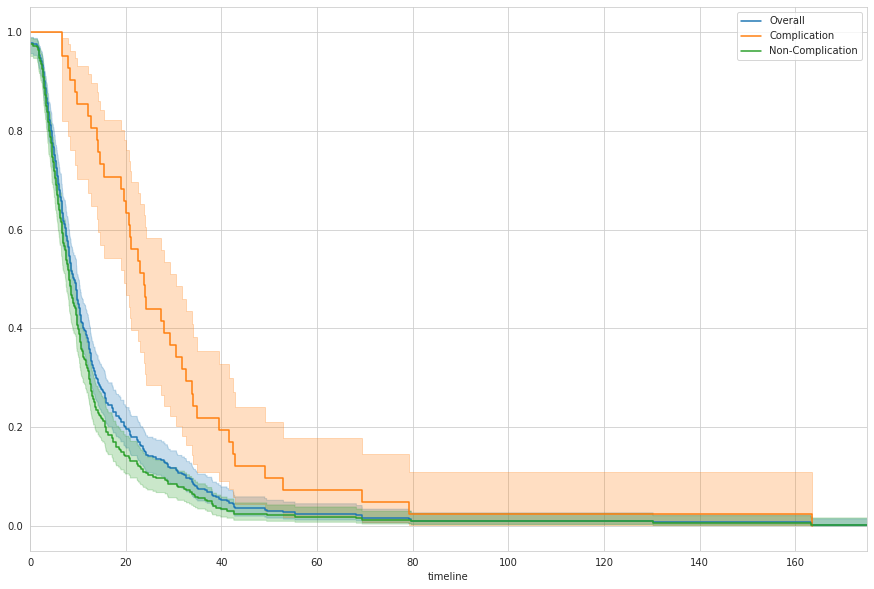

In [0]:
# stratify comp/uncomp
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes = plt.gca()
axes.set_xlim([0,175])
kmf.fit(durations = km_df['admis-anti'], 
        event_observed = km_df.meds, label = 'Overall')
ax = kmf.plot()
kmf_comp = km_df[km_df['infectious_complication_updated'] == 'Yes']
kmf.fit(durations = kmf_comp['admis-anti'], 
        event_observed = kmf_comp.meds, label = 'Complication')
ax = kmf.plot(ax=ax)
kmf_noncomp = km_df[km_df['infectious_complication_updated'] != 'Yes']
kmf.fit(durations = kmf_noncomp['admis-anti'], 
        event_observed = kmf_noncomp.meds, label = 'Non-Complication')
ax = kmf.plot(ax=ax)

In [0]:
def incdec_test(x, i, nf= False):
  temp = ''
  for x,y in  zip(test, test[1:]):
    if x > y:
      temp = temp + 'd'
    elif x < y:
      temp = temp + 'i'
    #else:
      #temp.append('-')
  if 'di' in temp:
    nf = True
  print('{}|{} |{}'.format( i,nf, temp))

for i in nsti_medt['patient.x'].unique():
  test = nsti_medt[nsti_medt['patient.x'] == i ]['total.time'].dt.floor('d').value_counts().rename_axis('date').reset_index(name='count').sort_values(by = 'date')['count'].to_list()
  n = len(test)
  if n != 1:
    incdec_test(test, i)

1|True |iiidddddddiid
10|True |iiiddididdid
102|True |did
103|False |iidddd
104|True |iidididdid
107|True |iiddididiidid
108|True |ididddid
109|True |iddid
11|True |diiddddddid
112|True |iddddiddiididid
113|True |iiidddiidddididid
114|True |iididd
115|False |iiid
116|False |iddddd
117|False |iddddd
118|True |iiddidddii
119|False |iddd
12|False |id
120|True |iddiddd
121|False |iidddd
122|False |id
125|True |idddidiidd
126|True |idididdd
128|False |iid
129|False |iidd
13|True |idididd
131|True |iiddddid
132|True |iiddidd
133|True |iddid
134|True |ddddiddididdidiidiiddiididiiddiddidd
135|False |iidd
137|True |iddiddd
139|True |iiddidd
14|False |idd
141|True |iiiddddi
142|False |iiddd
143|True |ididid
144|True |ididdd
145|True |diiddddd
146|False |iiddd
147|True |iddiidd
148|False |iiddd
149|False |iid
15|True |iiiddidddidddiid
150|True |iidiidddddidiididd
151|True |ididddid
153|True |iddid
154|False |iiddd
155|True |ididiiddddididd
156|False |idddd
157|False |idd
159|False |idd
16|False |

In [0]:
#https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count
# categorical breakdown with count 
testmedtpivot['patient.x'] = testmedtpivot.index
testmedtpivot.groupby(['CIPR', 'CLIN', 'GENT', 'LEVO', 'MERO', 'METR', 'PCNG', 'PIPE', 'VANC']).size().reset_index().rename(columns={0:'count'}).to_csv('ven_med.csv')

In [0]:
testmedtpivot.to_csv('ven_med.csv')

![alt text](https://drive.google.com/uc?id=1JnoP_EYVjGS47EspeBqadVSJk4Lu4TzG)



In [0]:
nsti_medt = nsti_medt.merge(nstit[['patient', 'admit.x']], how = 'left', left_on = 'study_id', right_on = 'patient')

In [0]:
#wbc_med[wbc_med['baseline'] != timedelta(0,0)].sort_values(by = ['baseline'])['baseline'].total_seconds()
wbc_med= wbc_med.merge(nstit[['patient', 'outcome']], how = 'left', left_on= 'study_id', right_on= 'patient')

In [0]:
nsti_merge = test[['patient', 'observationvalue', 'observationdttm_x', 'difference','meds', 'total.time']].merge(nstit, how = "left", on = "patient")

In [0]:
# shows the breakdown of outcome with observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'outcome', hue = 'race')
ax.xaxis.grid(True)

In [0]:
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'meds', hue = 'outcome')
ax.xaxis.grid(True)

In [0]:
# shows the breakdown of outcome with observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'sex', hue = 'outcome')
ax.xaxis.grid(True)

In [0]:
# shows the breakdown of outcome with observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'debride.count', y = 'observationvalue', hue = 'outcome')
ax.xaxis.grid(True)

In [0]:
# shows the breakdown of meds and observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'outcome', hue = 'meds')
ax.xaxis.grid(True)

In [0]:
#
fig, ax = plt.subplots(figsize=(20,6))
sns.distplot( nsti_merge[nsti_merge['outcome'] == 'D']['difference'].dt.seconds , bins = 15)
ax.xaxis.grid(True)

#nsti_merge['diff_hours'] = nsti_merge['difference'].dt.seconds / 3600

In [0]:
fig, ax = plt.subplots(figsize=(20,6))
sns.distplot( wbc_med[wbc_med['baseline'] < 1000]['baseline'] , bins = 1000)
ax.xaxis.grid(True)

In [0]:
#test.head()
nsti_merge#[nsti_merge['outcome'] == "D"]
nsti_merge['outcome']  = (nsti_merge['outcome'] == 'A')*1
#wbc_med.head()

In [0]:
#fig, ax = plt.subplots(figsize=(18,11))
#sns.regplot(x = 'observationvalue', y = 'outcome', data = nsti_merge, logistic = True, ax = ax)
sns.lmplot(x = 'observationvalue', y = 'outcome', data = nsti_merge, logistic = True, height = 10)

In [0]:
#fig, ax = plt.subplots(figsize=(60,11))
#g = sns.FacetGrid(height = 10,  data = wbc_med[wbc_med['baseline'] < 1000], col = 'outcome')
#g = g.map(sns.lineplot, 'baseline','observationvalue')

sns.lmplot( x =  'baseline',y = 'observationvalue', data = wbc_med[wbc_med['patient_x'] < 10][wbc_med['baseline'] < 1000], hue = 'outcome', height = 5, legend = False, row = 'patient_x')
#sns.lineplot(ax = ax, data = wbc_med[wbc_med['patient_x'] == 3],x = 'baseline', y = 'observationvalue', hue = 'outcome')
#ax.xaxis.grid(True)


## Creating a proxy dataset for just total time andy study id

In [0]:
# makes it so there isn't any duplicate 
nsti_med_max = nsti_medt[['study_id', 'total.time']]
nsti_med_max = nsti_med_max.drop_duplicates(subset = ['study_id', 'total.time'], keep = 'first')
idx = nsti_med_max.groupby(['study_id'])['total.time'].transform(max) == nsti_med_max['total.time']
       
nsti_med_max = nsti_med_max[idx]

# [nstit][nsti_debridet] Merger of nsti demo and debride data

In [0]:
# Merges the debride and nsti df to one 
nsti_full = nstit.merge(nsti_debridet, left_on= "patient", right_on = "study_id")

## Removing featuresfrom nsti_full

Removes Cost, deb, and rec data from the overall dataset while keeping it as a seperate dataset with identifiers 

- debisolate
- recisolate 

In [0]:
#Remove cost data
listcost = list(i for i in list(nsti_full.columns) if not (re.search(r'(costs)',i)))
nsti_full = nsti_full[listcost]

# removing the deb data 
listdeb = list(i for i in list(nsti_full.columns) if (re.search(r'^(deb)',i)))
debisolate = nsti_full[['patient']+listdeb]
nsti_full.drop(listdeb, axis = 1, inplace = True)

# removin the rec data
listrec = list(i for i in list(nsti_full.columns) if (re.search(r'^(rec)',i)))
recisolate = nsti_full[['patient']+listrec]
nsti_full.drop(listrec, axis = 1, inplace = True)

## Formatting the date in [nsti_full] and pulling the target variable

In [0]:
# Removing nulls
nsti_full = nsti_full[nsti_full['minutes.from'] != "NA"]

#Formating string dates to timedate type
nsti_full['admit.x'] = pd.to_datetime(nsti_full['admit.x'], format = '%m/%d/%Y')
nsti_full['discharge'] = pd.to_datetime(nsti_full['discharge'], format = '%m/%d/%Y')
nsti_full['minutes.from'] = pd.to_numeric(nsti_full['minutes.from']).apply(lambda x: timedelta(minutes = x))

# Making a feature that combines the minutes from {admit to last debridement} 
# and the date of the admission to get rough time of the actual time date of debridement
nsti_full['admittodeb'] = nsti_full['admit.x'] + nsti_full['minutes.from']

## TASK: Find the difference in time between the last debridement and last medication 

- Status: Completed 

- Notes: 

The main issue is that there are negative values when it should be mostly positive.

It was noted that for some of the patients, incomplete data as well as wrong indication towards data usage.

Manual picking is needed 

- Updates: Need to work off of the new dataset

In [0]:
# making sure that the dataset only has positive variables 
nsti_complete = nsti_full.merge(nsti_med_max, left_on = 'patient', right_on= 'study_id' )

# Creating a new feature in the difference in hours 
nsti_complete['debtomed'] = (nsti_complete['total.time'] - nsti_complete['admittodeb']) / np.timedelta64(1, 'h') 
nsti_complete = nsti_complete.loc[nsti_complete['debtomed'] >= 0.0]
nsti_complete = nsti_complete[nsti_complete.columns[~nsti_complete.columns.str.contains('minutes')]]

# Cleaning up the dataset by eliminating some of the extra features 
nsti_complete.drop(['discharge','sex','admit.x','location.code.1', 'location.code.2','icd.10.code..1', 'icd.10..1.description','icd.10.code..2','icd10..2.descrition','admit.y',
                    'insure','insure_type','admit.date.x.x','dc_date','transfer_y','dc.dispo','admittodeb', 'total.time','study_id_y','study_id_x','transfer_x'], axis = 1, inplace = True)

# Model creation 

Under construction need some more work and understand of the data 

# Feature encoding 

Need to figure out what exactly to encode some of the features 

In [0]:
nsti_complete_filter = nsti_complete[nsti_complete['debtomed'] <5000]

binary_change = {"outcome": {"A": 1, "D": 0}}

nsti_complete_filter.replace(binary_change, inplace=True)
nsti_complete_filter.head()

#https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
nsti_complete_filter = pd.get_dummies(nsti_complete_filter, columns =['mechanism.of.infection', 'race'])

dummy_code = pd.get_dummies(nsti_complete_filter['comorbid.codes'].str.split(';').apply(pd.Series).stack()).sum(level=0)
dummy_region = pd.get_dummies(nsti_complete_filter['region'].str.split('; ').apply(pd.Series).stack()).sum(level=0)
df_dummyfull = pd.concat([dummy_code,dummy_region],axis=1,join = 'inner')
nsti_new = pd.concat([nsti_complete_filter, dummy_region], axis = 1)
nsti_new.drop(['region','patient','comorbid.codes','co.morbids','icu.los','icu.hours','hosp.los', 'vent.days'], axis = 1, inplace = True)

Converting to all floats 

In [0]:
# see how many na are there
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nsti_new.dropna().isnull(), cbar=False, cmap="YlGnBu_r")
fig.patch.set_facecolor('xkcd:mint green')
plt.show()

#nsti_new.dropna(axis=1,how='all')

In [0]:
corr = nsti_new.corr()

In [0]:
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap = "PiYG")


Doesn't seem to be that much correlation for our target 

Feature selection

In [0]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

nsti_new = nsti_new.dropna()
y = nsti_new['debtomed']
y = y.astype('int')
nsti_new.drop(['debtomed','unnamed:_0'], axis = 1, inplace = True)
X = nsti_new

# Univariate selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

#tasks: Need to convert other strings to numerical or numeraid

In [0]:
model = LinearRegression().fit(X[['age','race_','mechanism.of.infection_BURN', 'cauti','vap','bleeding','pe','unplanned.ett','unplanned.or','cpr']], y)

r_sq = model.score(X[['age','race_','mechanism.of.infection_BURN', 'cauti','vap','bleeding','pe','unplanned.ett','unplanned.or','cpr']], y)
print('coefficient of determination:', r_sq)


Seeing as a linear regression doesn't really help with this